# **Group Project Proposal**
### *Classifying Cammeo and Osmancik Rice Grains*

<img align="left" src="https://turkishmart.ca/cdn/shop/products/Turkishmart_rice-sale-in-superstore_1024x1024.jpg?v=1665713014" width="300" />

*Source: https://turkishmart.ca/products/reis-osmancik-rice-1kg/*
## 1. Introduction

Rice is arguably the most important crop globally due to its economic and nutritional value. Here we will examine more closely into two rice species cultivated in Turkey - Osmancik and Cammeo - and how we can use the data to classify between the two. Although the duo share the same wide, long with a glassy, dull appearance, we aim to train our model to distinguish the two using other specifications. An accumulated 3810 images of rice were taken and 7 structural features were obtained for each grain of rice. 

## 2. Preliminary Exploratory Data Analysis
Before exploring the data, we first load several packages in order to clean and wrangle the data which will be visualized later.


In [1]:
### Run this cell to load packages and set options
library(tidyverse)
library(tidymodels)
library(janitor)
library(repr)

options(repr.matrix.max.rows = 6)
options(repr.plot.width = 12, repr.plot.height = 12)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### I. Demonstrate that the dataset can be read from the web into R 


In [2]:
### Reading data set from the web
url <- "https://raw.githubusercontent.com/trungnguyen21/group_project_dsci/main/data/rice_data.csv"
rice_data <- read_csv(url)
rice_data

New names:
• `` -> `...1`
Rows: 3810 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Class
dbl (8): ...1, Area, Perimeter, Major_Axis_Length, Minor_Axis_Length, Eccent...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,15231,525.579,229.7499,85.09379,0.9288820,15617,0.5728955,b'Cammeo'
1,14656,494.311,206.0201,91.73097,0.8954050,15072,0.6154363,b'Cammeo'
2,14634,501.122,214.1068,87.76829,0.9121181,14954,0.6932588,b'Cammeo'
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3807,12437,442.499,183.5729,86.80198,0.8811443,12645,0.6267385,b'Osmancik'
3808,9882,392.297,161.1940,78.21048,0.8744061,10097,0.6590636,b'Osmancik'
3809,11434,404.710,161.0793,90.86819,0.8256922,11591,0.8029494,b'Osmancik'


#### II. Clean and wrangle your data into a tidy format


In [3]:
### Cleaning data set: cleaning names, renaming class and changing to factor, and removing first column
rice <- rice_data |>
  clean_names() |>
  mutate(class = as_factor(class),
         class = fct_recode(class, "Cammeo" = "b'Cammeo'", "Osmancik" = "b'Osmancik'")) |>
  select(-x1)
rice

area,perimeter,major_axis_length,minor_axis_length,eccentricity,convex_area,extent,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
15231,525.579,229.7499,85.09379,0.9288820,15617,0.5728955,Cammeo
14656,494.311,206.0201,91.73097,0.8954050,15072,0.6154363,Cammeo
14634,501.122,214.1068,87.76829,0.9121181,14954,0.6932588,Cammeo
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
12437,442.499,183.5729,86.80198,0.8811443,12645,0.6267385,Osmancik
9882,392.297,161.1940,78.21048,0.8744061,10097,0.6590636,Osmancik
11434,404.710,161.0793,90.86819,0.8256922,11591,0.8029494,Osmancik


In [4]:
### Splitting data set into training and testing data sets
rice_split <- initial_split(rice, prop = 0.75, strata = class)
rice_train <- training(rice_split)
rice_test <- testing(rice_split)

#### III. Summarize the training data

In [5]:
### Summary table: means of each predictor, missing data count, and number of observations
rice_train_summary <- rice_train |>
  mutate(na_count = rowSums(is.na(rice_train))) |>
  group_by(class) |>
  summarize(across(area:na_count, mean), obs = n())
rice_train_summary

class,area,perimeter,major_axis_length,minor_axis_length,eccentricity,convex_area,extent,na_count,obs
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Cammeo,14154.83,487.1993,205.3658,88.76706,0.9009018,14484.77,0.6504838,0,1222
Osmancik,11550.75,429.4870,176.2244,84.52416,0.8760788,11802.04,0.6689829,0,1635


#### IV. Visualize the training data

In [6]:
### Pivot long rice training set
rice_train_long <- rice_train |>
  pivot_longer(cols = area:extent, names_to = "predictor", values_to = "value")
rice_train_long

class,predictor,value
<fct>,<chr>,<dbl>
Cammeo,area,14656.0000
Cammeo,perimeter,494.3110
Cammeo,major_axis_length,206.0201
⋮,⋮,⋮
Osmancik,eccentricity,8.256922e-01
Osmancik,convex_area,1.159100e+04
Osmancik,extent,8.029494e-01


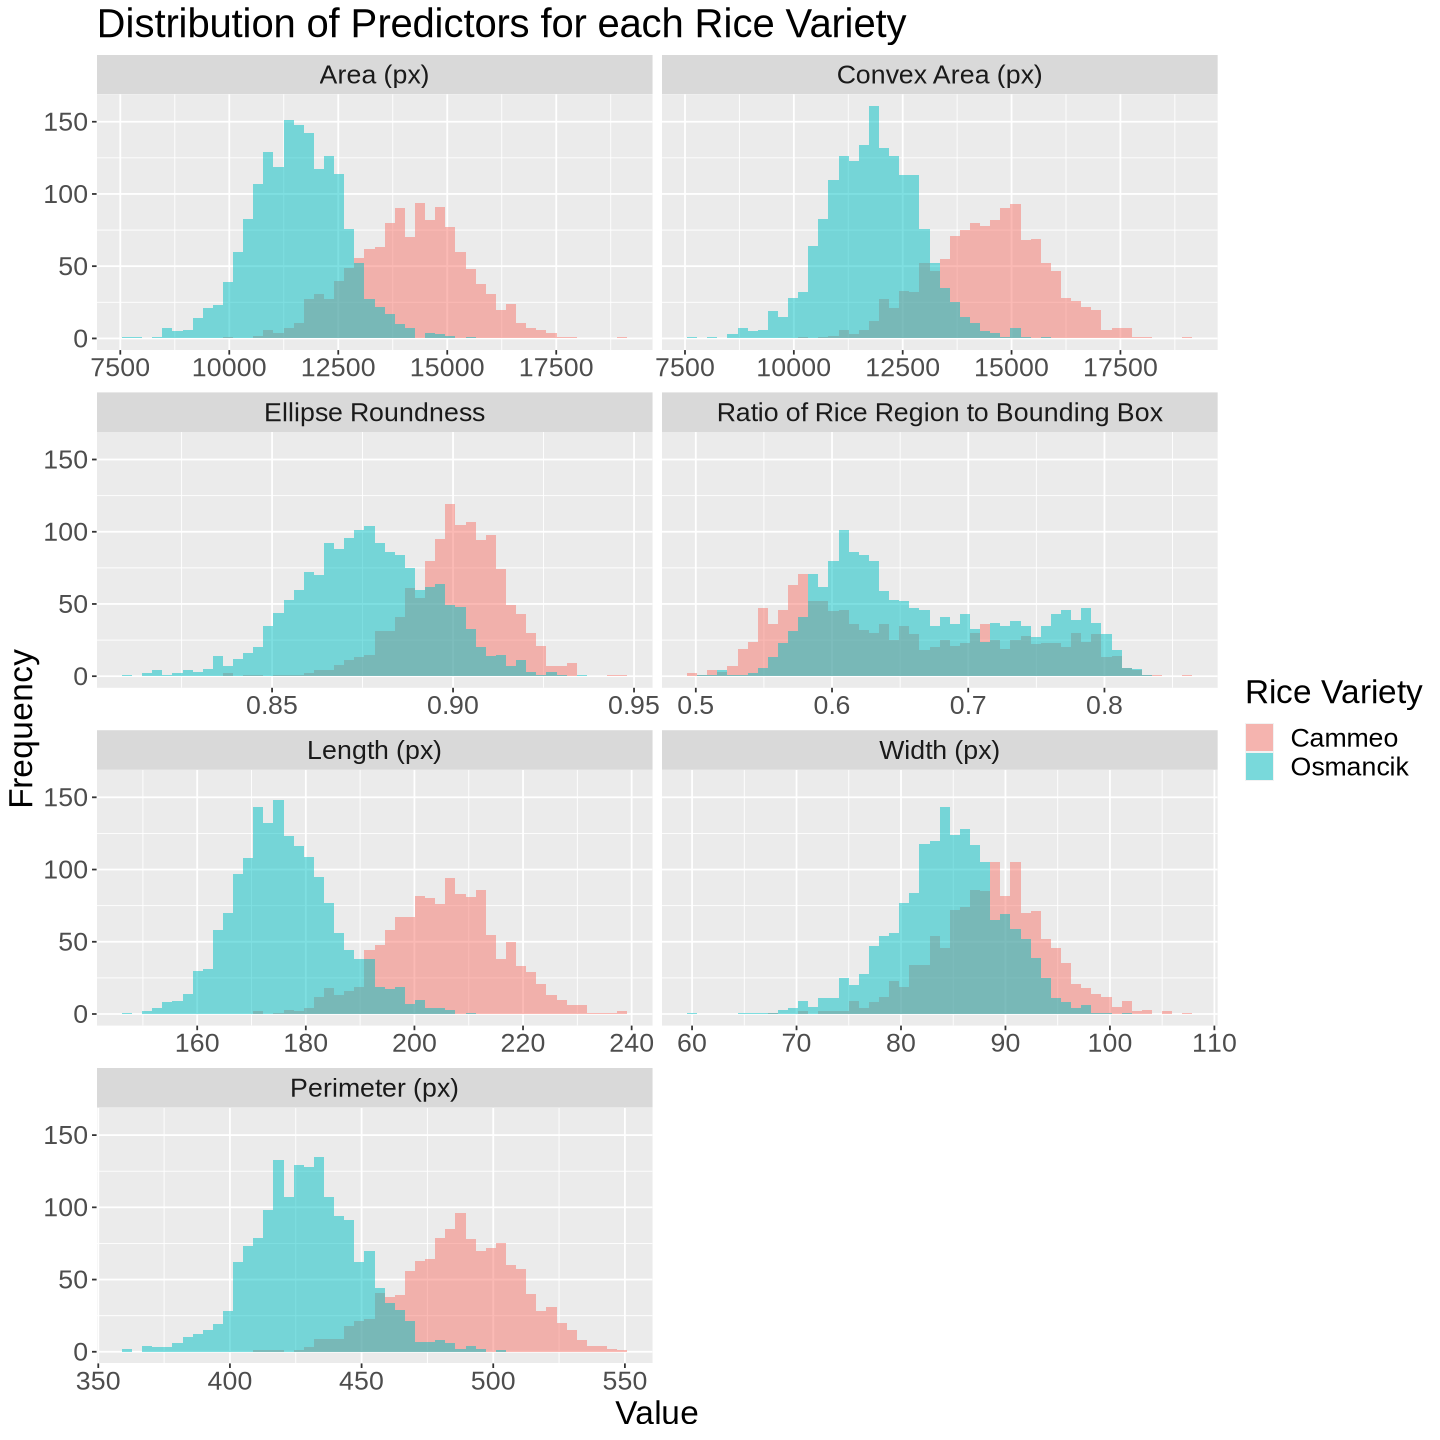

In [8]:
### Create readable labels for the histograms 
rice_labels <- c(
  area = "Area (px)",
  perimeter = "Perimeter (px)",
  major_axis_length = "Length (px)",
  minor_axis_length = "Width (px)",
  eccentricity = "Ellipse Roundness",
  convex_area = "Convex Area (px)",
  extent = "Ratio of Rice Region to Bounding Box")

### Create histograms for each predictor
rice_hist <- rice_train_long |>
  ggplot(aes(x = value, fill = class)) +
  geom_histogram(alpha = 0.5, position = "identity", bins = 50) +
  facet_wrap(~predictor, scales = "free_x", labeller = labeller(predictor = rice_labels), ncol = 2) +
  labs(title = "Distribution of Predictors for each Rice Variety",
       x = "Value", 
       y = "Frequency", 
       fill = "Rice Variety") +
  theme(text = element_text(size = 20))
rice_hist

## 3. Methods
After preliminary exploratory data analysis, it’s clear that the variables with the clearest different distributions between the 2 classes are “area”, “convex area”, “length”, and “perimeter”. The variables “ellipse roundness” and “width” have some overlap, but may still be useful. “Ratio of rice region to bounding box” will most likely be the only variable of the 7 that will not be used, as there is considerable overlap of distribution between the 2 classes. 
In addition to to creating a basic K-nearest classifier using what was discussed above, we plan to use forward selection as shown in the optional Chapter 6.8 to systematically find the best variables to use to optimize our classifier.

## 4. Expected Outcomes and Significance
We expect that morphological features of rice such as its length, area, and perimeter can be used to successfully and accurately identify the species of rice. The ability to predict rice species by measuring simple physical characteristics is important in the context of agriculture and economics. The predictive analysis can be used as a quality control measure while processing and setting prices for the different varieties of rice. As a future direction, other predictors such as the nutritional content of the different species can be looked into. How this model can be expanded to species of rice other than Cammeo and Osmancik can also be explored.  